In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
# load dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bengaluruaqi.csv", header=0, index_col=0)
values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,6] = encoder.fit_transform(values[:,6])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
317   0.084971   0.422616   0.056371   0.230487   0.043478   0.021321   
322   0.056434   0.023887   0.043386   0.207221   0.041398   0.021973   
323   0.064995   0.092167   0.069883   0.348649   0.035989   0.024149   
324   0.039023   0.067640   0.067349   0.198299   0.035781   0.019254   
325   0.045981   0.046987   0.043386   0.176201   0.019555   0.025998   

     var7(t-1)  var8(t-1)   var1(t)  
317        0.6   0.123494  0.130503  
322        0.2   0.319277  0.064995  
323        0.2   0.250000  0.039023  
324        0.6   0.162651  0.045981  
325        0.6   0.138554  0.048899  


In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = 1164
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1164, 1, 8) (1164,) (245, 1, 8) (245,)


In [ ]:
test_y


In [12]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
17/17 - 4s - loss: 0.0832 - val_loss: 0.0302 - 4s/epoch - 236ms/step
Epoch 2/50
17/17 - 0s - loss: 0.0444 - val_loss: 0.0243 - 91ms/epoch - 5ms/step
Epoch 3/50
17/17 - 0s - loss: 0.0398 - val_loss: 0.0302 - 90ms/epoch - 5ms/step
Epoch 4/50
17/17 - 0s - loss: 0.0385 - val_loss: 0.0281 - 87ms/epoch - 5ms/step
Epoch 5/50
17/17 - 0s - loss: 0.0375 - val_loss: 0.0269 - 99ms/epoch - 6ms/step
Epoch 6/50
17/17 - 0s - loss: 0.0365 - val_loss: 0.0273 - 96ms/epoch - 6ms/step
Epoch 7/50
17/17 - 0s - loss: 0.0360 - val_loss: 0.0267 - 91ms/epoch - 5ms/step
Epoch 8/50
17/17 - 0s - loss: 0.0354 - val_loss: 0.0269 - 99ms/epoch - 6ms/step
Epoch 9/50
17/17 - 0s - loss: 0.0350 - val_loss: 0.0263 - 88ms/epoch - 5ms/step
Epoch 10/50
17/17 - 0s - loss: 0.0346 - val_loss: 0.0259 - 99ms/epoch - 6ms/step
Epoch 11/50
17/17 - 0s - loss: 0.0342 - val_loss: 0.0257 - 110ms/epoch - 6ms/step
Epoch 12/50
17/17 - 0s - loss: 0.0338 - val_loss: 0.0252 - 98ms/epoch - 6ms/step
Epoch 13/50
17/17 - 0s - loss: 0.033

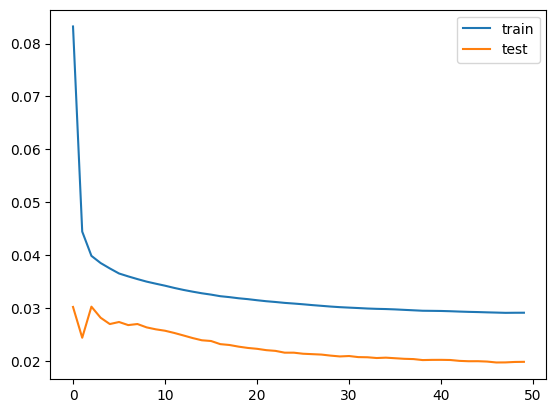

In [14]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


8/8 [==============================] - 1s 4ms/step


In [63]:
test_X

array([[0.05467022, 0.09907076, 0.12086984, ..., 0.06189492, 0.6       ,
        0.1746988 ],
       [0.05418925, 0.12155904, 0.07315528, ..., 0.05438921, 0.6       ,
        0.14457831],
       [0.08240613, 0.20079233, 0.12203104, ..., 0.05732623, 0.6       ,
        0.19277108],
       ...,
       [0.06002501, 0.05278336, 0.02354059, ..., 0.06385294, 0.6       ,
        0.12349398],
       [0.08644628, 0.06131842, 0.03335796, ..., 0.06091591, 0.6       ,
        0.13554215],
       [0.04088242, 0.04672435, 0.04380872, ..., 0.06222126, 0.6       ,
        0.12951806]], dtype=float32)

In [16]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


In [62]:
inv_yhat

array([19.492985, 19.38324 , 27.580694, 26.294346, 34.676594, 46.639675,
       64.34025 , 78.48943 , 77.34547 , 60.355663, 43.687634, 45.03756 ,
       53.932293, 27.880314, 29.50095 , 23.636946, 25.222757, 21.847296,
       28.080666, 25.318634, 20.718496, 21.222076, 36.28035 , 38.261497,
       32.727547, 34.869125, 32.622402, 32.03583 , 29.936943, 23.191715,
       22.922852, 22.358644, 15.647161, 15.675226, 25.090343, 33.34944 ,
       45.518173, 48.681374, 34.622074, 22.849781, 21.496065, 21.15148 ,
       26.596783, 27.326002, 28.492846, 23.453487, 24.695171, 23.598822,
       25.474203, 37.037724, 34.257103, 38.877224, 41.823994, 39.668026,
       41.963814, 32.825474, 31.216993, 38.932198, 38.58284 , 31.751703,
       33.83722 , 40.508774, 38.097992, 29.162418, 25.335596, 28.425615,
       45.10751 , 46.986275, 24.64241 , 23.126095, 30.050201, 37.799416,
       35.838524, 28.759964, 34.357418, 46.828136, 54.79706 , 41.304462,
       38.03171 , 34.799618, 26.458017, 24.529995, 

In [17]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [64]:
inv_y

array([18.62    , 27.42    , 27.1     , 40.      , 54.83    , 73.88    ,
       94.17    , 92.21    , 69.3     , 47.139996, 52.86    , 61.83    ,
       27.77    , 30.39    , 23.32    , 26.33    , 20.62    , 30.7     ,
       27.07    , 20.229998, 21.12    , 42.28    , 44.17    , 36.68    ,
       41.18    , 37.44    , 35.44    , 33.02    , 23.08    , 22.97    ,
       23.25    , 13.46    , 13.960001, 27.28    , 38.2     , 55.45    ,
       57.3     , 39.42    , 23.79    , 21.29    , 20.31    , 28.62    ,
       28.93    , 30.65    , 23.6     , 25.33    , 24.25    , 27.65    ,
       42.91    , 38.66    , 44.46    , 48.62    , 46.52    , 49.33    ,
       35.84    , 35.48    , 44.27    , 43.32    , 35.24    , 38.53    ,
       47.81    , 42.54    , 30.71    , 25.78    , 29.66    , 52.62    ,
       52.64    , 24.74    , 22.52    , 30.920002, 40.57    , 39.29    ,
       31.1     , 39.5     , 53.93    , 64.35    , 45.19    , 39.359997,
       34.68    , 26.9     , 26.66    , 34.51    , 

In [ ]:
arr = np.random.rand(6).reshape(2, 3)
print("Numpy array:")
print(arr)

# convert numpy array to dataframe
df = pd.DataFrame(arr,

In [65]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.233


In [74]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load your historical air quality data (replace 'your_data.csv' with your dataset)
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bengaluruaqi.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')  # Specify the correct date format
data.set_index('Date', inplace=True)  # Set Date as the index

# Define the air quality metric you want to predict (e.g., AQI)
target_column = 'AQI'
#start_date = data['Date'].iloc[0]
#end_date = data['Date'].iloc[0]

# Split data into training and testing sets (you can adjust the split as needed)
train_data = data.loc['01-01-2015':'31-12-2019']
test_data = data.loc['01-01-2020':'31-12-2020']

# Perform autoregressive modeling
lag_order = 3  # Number of lagged values to consider (adjust as needed)
model = sm.tsa.AR(train_data[target_column]).fit(maxlag=lag_order)

# Predict future air quality values
future_periods = 7  # Number of future periods to predict
forecast_values = model.forecast(steps=future_periods)

# Create a date range for the forecasted periods
forecast_dates = pd.date_range(start=train_data.index[-1], periods=future_periods+1, closed='right')

# Plot historical data and future predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data[target_column], label='Historical Data')
plt.plot(forecast_dates, forecast_values, label='Future Predictions', linestyle='--', marker='o', color='r')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.title('Air Quality Forecast')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-74-8afbf317709c>:17: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  train_data = data.loc['01-01-2015':'31-12-2019']
<ipython-input-74-8afbf317709c>:18: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test_data = data.loc['01-01-2020':'31-12-2020']


NotImplementedError: ignored

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, train_X['AQI'], label='Historical Data')
plt.plot(forecast_dates, forecast_values, label='Future Predictions', linestyle='--', marker='o', color='r')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.title('Air Quality Forecast')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-79-6a7226b378ce>:4: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=df.index[-1], periods=10+1, closed='right')


TypeError: ignored

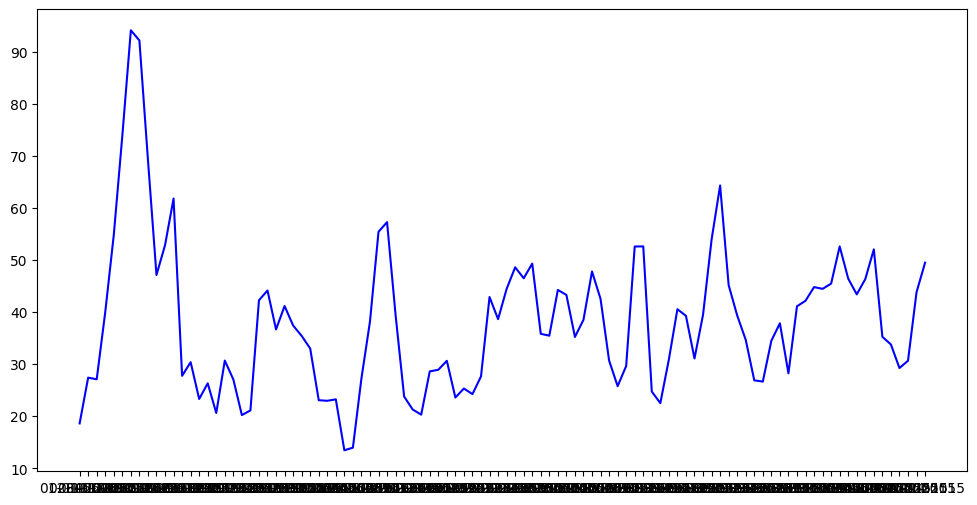

In [79]:
results = pd.DataFrame({'Actual': inv_y, 'Predicted': inv_yhat})


forecast_dates = pd.date_range(start=df.index[-1], periods=10+1, closed='right')
# Plot the continuous graph for previous and predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index[:100,], results['Actual'].head(100), label='Actual', color='blue')
plt.plot(forecast_dates, results['Predicted'], label='Predicted', color='red')

# Add labels, title, and legend
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Continuous Previous and Predicted Values in Time Series')
plt.legend()

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

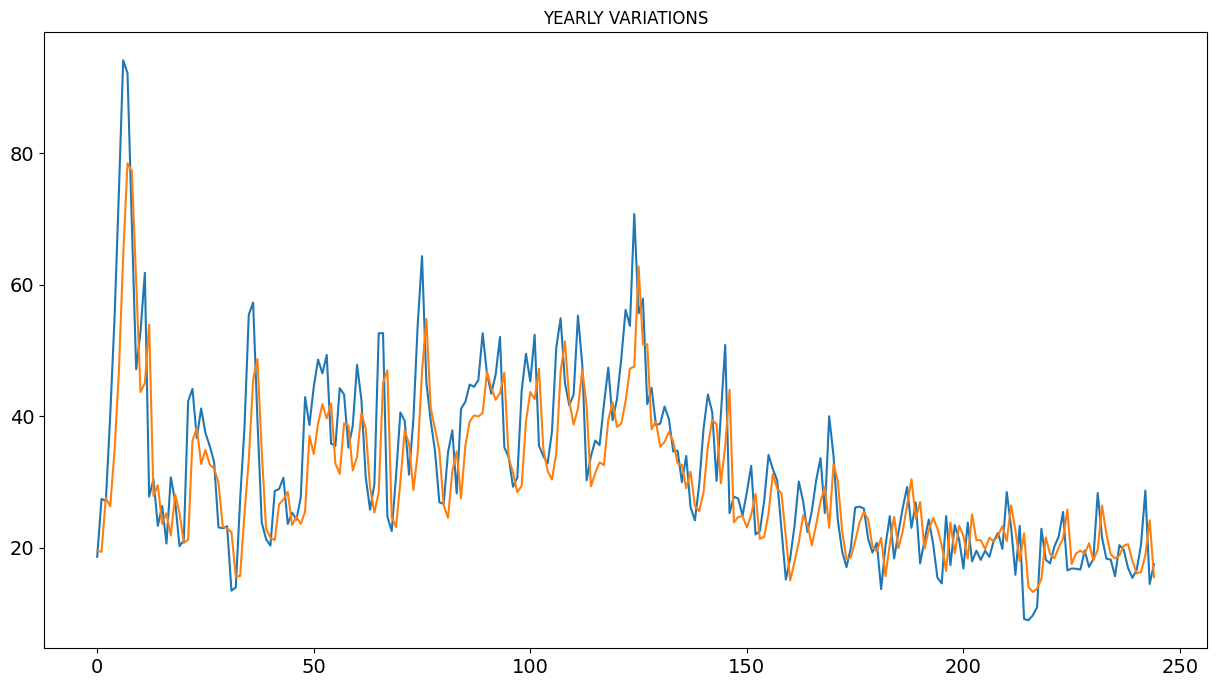

In [52]:
results['Actual'].plot(figsize=(15,8), title= 'YEARLY VARIATIONS', fontsize=14)
results['Predicted'].plot(figsize=(15,8), title= 'YEARLY VARIATIONS', fontsize=14)
plt.show()

IndexError: ignored

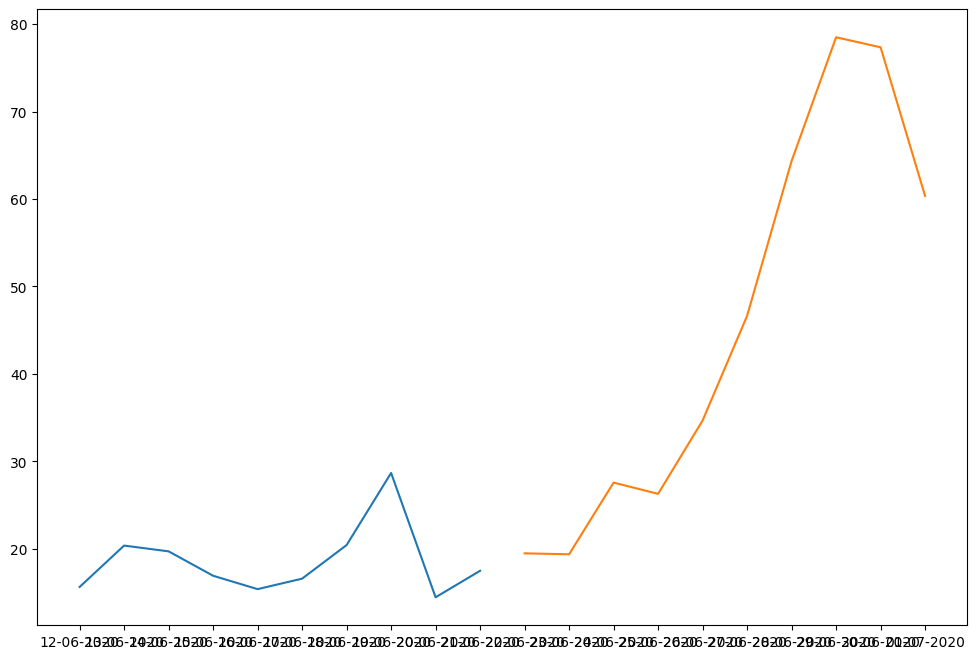

In [72]:
plt.figure(figsize=(12,8))
plt.plot(df.index[-20:-10], results['Actual'].tail(10), label='Train')
plt.plot(df.index[-10:], results['Predicted'].head(10), label='Test')
plt.plot(df.index,inv_yhat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast",fontsize=20)

plt.legend(["actual ","predicted"])
plt.xlabel("YEAR",fontsize=20)
plt.ylabel("AQI",fontsize=20)
plt.tick_params(labelsize=20)
plt.show()